In [1]:
# 02_main.ipynb
from grav_lens import get_datasets
from grav_lens.models import test_model_image

from utils.model import create_model
from utils.loadsave import load_model_with_hyperparameters, load_hyperparameters, save_hyperparameters
from utils.optimize import dimensions, default_parameters

import time
import pickle

from tensorflow.keras import backend as K

import tensorflow.keras.activations as activations
import os 

# se permite el uso de rutas absolutas ahora
home_data = os.path.join("..","..","data")


# INDEX 0 es una carpeta de datasets mucho mas chica
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=32*4, 
    home=home_data)


Using data folder: ..\..\data\1


In [2]:

for X, Y in train_dataset.take(1):  # Mostrar un batch de entrenamiento
    print("Train X:", X.shape)
    print("Train Y:", Y.shape)

for X, Y in val_dataset.take(1):  # Mostrar un batch de validación
    print("Val X:", X.shape)
    print("Val Y:", Y.shape)

for X, Y in test_dataset.take(1):  # Mostrar un batch de prueba
    print("Test X:", X.shape)
    print("Test Y:", Y.shape)


Train X: (32, 128, 128, 3)
Train Y: (32, 128, 128, 1)
Val X: (25, 128, 128, 3)
Val Y: (25, 128, 128, 1)
Test X: (12, 128, 128, 3)
Test Y: (12, 128, 128, 1)


# Arquitectura para lab
Aqui es posible tener acceso a lo que seria el `model.py`, sin necesaidad de resetear todo el tiempo

In [3]:
import tensorflow as tf

# caxar si la metrica DICEE es diferenciable
@tf.function
def dice_loss_bin(y_true, y_pred):
    mean_true = tf.reduce_mean(y_true)
    mean_pred = tf.reduce_mean(y_pred)
 
    y_true_bin = activations.sigmoid(y_true - mean_true)
    y_pred_bin = activations.sigmoid(y_pred - mean_pred)
 
    intersection = tf.reduce_sum(y_true_bin * y_pred_bin)
    dice_coefficient = (2. * intersection + 1e-7) / (tf.reduce_sum(y_true_bin) + tf.reduce_sum(y_pred_bin) + 1e-7)
 
    return 1 - dice_coefficient

@tf.function
def ssim_loss(y_true, y_pred):
    # Ajustar el rango dinámico según la escala de tus imágenes [-1, 1] 
    max_val = 2.0  # Porque las imágenes están en el rango [-1, 1]
    ssim_index = tf.image.ssim(y_true, y_pred, max_val=max_val)
    return 1 - tf.reduce_mean(ssim_index)  # Minimiza 1 - SSIM para maximizar SSIM



mape_callable = tf.keras.losses.MeanAbsolutePercentageError(
    reduction='sum_over_batch_size',
    name='mean_absolute_percentage_error'
)


# def combined_loss(weight_kl=0.1, weight_dice = 32768, weight_mape = 1):
#     #  32768 es igual al MAE maximo asumiendo ranogs (-1,1) con 128x128 pixeles
#     def loss(y_true, y_pred):
#         mae_loss = tf.keras.losses.mae(y_true, y_pred)
#         # kl_loss = tf.keras.losses.kld(y_true, y_pred) # requeire modificacion
#         dice_loss = dice_loss_bin(y_true, y_pred)
#         mape_loss = mape_callable(y_true, y_pred)
#         return mae_loss + weight_kl * kl_loss + weight_dice * dice_loss + weight_mape * mape_loss
#     return loss

class IdentityLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return inputs



In [4]:
from grav_lens import metrics
dir(metrics)

['DICEE',
 'DICE_binary_mask',
 'DPEAKS',
 'WMAPE',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'find_top_k_peaks',
 'scoring_challenge']

In [5]:
# TOOD Agregar regularizacion de dropout

def create_model(learning_rate=1e-4, 
                 h_kernel_size=3, 
                 hidden_filters=64,
                 out_kernel_size=3,
                 epsilon=1e-7):
    """
    Modelo que agranda las dimensiones espaciales hasta 256x256 y luego las reduce a 128x128.
    """
    initializer = tf.keras.initializers.GlorotNormal()
    input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
    #x = tf.keras.layers.BatchNormalization()(input_layer)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation="sigmoid", padding='same', kernel_initializer=initializer)(input_layer)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        hidden_filters, (h_kernel_size, h_kernel_size), kernel_initializer=initializer, 
        activation="softplus", padding='same')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(x)
    output_image = tf.keras.layers.Conv2D(1, (out_kernel_size, out_kernel_size), 
                                          activation="tanh", padding='same', name='output_image', 
                                          kernel_initializer=initializer)(x)


    # Salidas adicionales para las pérdidas, usando la capa de identidad personalizada
    # output_mae = tf.keras.layers.Lambda(lambda x: x, name='output_mae')(output_image)
    # output_mae = IdentityLayer(name='output_mae')(output_image)
    # output_mse = IdentityLayer(name='output_mse')(output_image)
    # #output_kld = IdentityLayer(name='output_kld')(output_image)
    # output_dice = IdentityLayer(name='output_dice')(output_image)

    model = tf.keras.models.Model(inputs=input_layer, 
        #outputs=[output_image, output_mae])
        outputs=[output_image, output_image] )#, output_mse,
        # output_kld, 
        #output_dice])


    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #   initial_learning_rate=learning_rate,
    #   decay_steps=decay_steps,
    #   decay_rate=decay_rate,
    #   staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                         epsilon=epsilon)

    # Compile con múltiples funciones de pérdida
    model.compile(optimizer=optimizer, 
                loss= ['mse', 'mae'],
                metrics={'output_image': [metrics.DICEE, metrics.WMAPE]})

    return model

#folder = 'results_2_dani'
#hyperparameter = load_hyperparameters(2, folder)

model = create_model()
model.summary()

#history = model.fit(train_dataset, epochs=10, verbose=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,089 (238.63 KB)

 Trainable params: 61,089 (238.63 KB)

 Non-trainable params: 0 (0.00 B)

# Training pequeño

In [6]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=100, 
    home=home_data)

Using data folder: ..\..\data\1


In [7]:
def count_elements_in_dataset(dataset):
    return sum(1 for _ in dataset)

train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=100, home=home_data)

# Contamos los elementos en cada dataset
train_count = count_elements_in_dataset(train_dataset)

Using data folder: ..\..\data\1


In [8]:
val_count = count_elements_in_dataset(val_dataset)
test_count = count_elements_in_dataset(test_dataset)

print(f"Train samples: {train_count}")
print(f"Validation samples: {val_count}")
print(f"Test samples: {test_count}")

Train samples: 2
Validation samples: 1
Test samples: 1


In [9]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,089 (238.63 KB)

 Trainable params: 61,089 (238.63 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import numpy as np

for _ in train_dataset:
	print(np.sum(_[0]), np.sum(_[1]))
	
for _ in val_dataset:
	print(np.sum(_[0]), np.sum(_[1]))

247.48155 2547.6382
76.87365 2318.2063
293.98538 2544.1455


In [11]:

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=True)


Epoch 1/5
      2/Unknown 7s 2s/step - loss: 0.0986 - output_image_dicee: 0.8281 - output_image_wmape: 93.2088 

C:\Users\fbien.DESKTOP-6FMEAR7\Documents\python\lib\contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.0817 - output_image_dicee: 0.7158 - output_image_wmape: 77.4154 - val_loss: 0.0477 - val_output_image_dicee: 0.2163 - val_output_image_wmape: 41.8392
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.0487 - output_image_dicee: 0.3832 - output_image_wmape: 64.7517 - val_loss: 0.0481 - val_output_image_dicee: 0.2162 - val_output_image_wmape: 42.1201
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.0364 - output_image_dicee: 0.3875 - output_image_wmape: 55.0515 - val_loss: 0.0157 - val_output_image_dicee: 0.2623 - val_output_image_wmape: 7.8755
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.0172 - output_image_dicee: 0.4996 - output_image_wmape: 20.2610 - val_loss: 0.0411 - val_output_image_dicee: 0.3670 - val_output_image_wmape: 36.0901
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.0350 - output_image_dicee: 0.6484 - output_image_wmape: 51.1165 - val_loss: 0.0272 - val_output_image_dicee: 0.3194 - val_output_im

In [12]:
history.history

{'loss': [0.04768689349293709,
  0.03923967853188515,
  0.02399117685854435,
  0.014452479779720306,
  0.02605595253407955],
 'output_image_dicee': [0.4912191927433014,
  0.28617990016937256,
  0.2929288446903229,
  0.39119768142700195,
  0.4845782518386841],
 'output_image_wmape': [45.828678131103516,
  52.01121139526367,
  36.33620071411133,
  19.34883689880371,
  38.28384780883789],
 'val_loss': [0.04772161692380905,
  0.048122577369213104,
  0.015747446566820145,
  0.041122715920209885,
  0.02716171182692051],
 'val_output_image_dicee': [0.21631956100463867,
  0.2161584198474884,
  0.26225364208221436,
  0.3670078217983246,
  0.3194008469581604],
 'val_output_image_wmape': [41.8392333984375,
  42.12012481689453,
  7.875471115112305,
  36.09014129638672,
  25.406030654907227]}

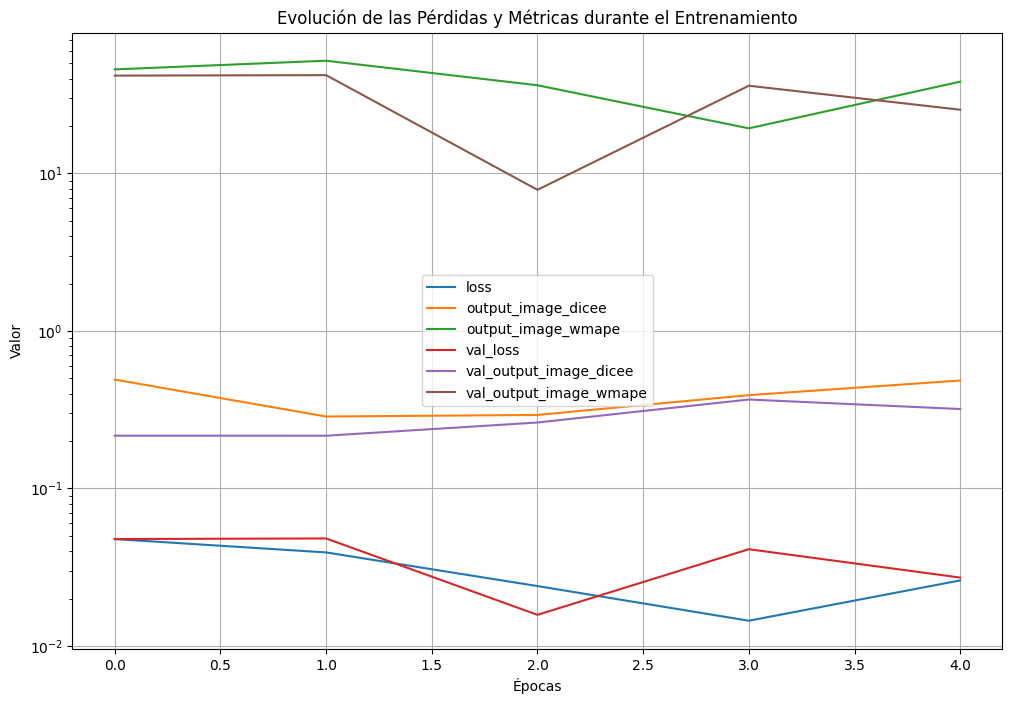

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una figura
plt.figure(figsize=(12, 8))

# Graficar cada métrica en history.history
for key in history.history.keys():
    plt.plot(history.history[key], label=key)

plt.yscale('log')
# Configurar los detalles de la gráfica
plt.title('Evolución de las Pérdidas y Métricas durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


# Training Significativo

In [14]:
# Primero un callback para setera tiempo maximo
import time
import pickle

class TimeLimitCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_hours=3, filepath='model_weights.h5', history_filepath='history.pkl'):
        super(TimeLimitCallback, self).__init__()
        self.max_seconds = max_hours * 60 * 60
        self.start_time = None
        self.filepath = filepath
        self.history_filepath = history_filepath

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_batch_end(self, batch, logs=None):
        if time.time() - self.start_time > self.max_seconds:
            self.model.stop_training = True

    def on_train_end(self, logs=None):
        # Guardar los pesos del modelo
        self.model.save_weights(self.filepath)

        # Guardar el history en formato pickle
        with open(self.history_filepath, 'wb') as f:
            pickle.dump(self.model.history.history, f)
        print(f"Model weights saved to {self.filepath}")
        print(f"Training history saved to {self.history_filepath}")

# Crear una instancia del callback
time_limit_callback = TimeLimitCallback(max_hours=3, filepath='0830.weights.h5', history_filepath='history.pkl')


In [15]:
model = create_model()

In [16]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=1000, 
    home=home_data)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, verbose=True, callbacks=[time_limit_callback])

Using data folder: ..\..\data\1
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.2844 - output_image_dicee: 0.5115 - output_image_wmape: 167.8597 - val_loss: 0.0025 - val_output_image_dicee: 0.3900 - val_output_image_wmape: 3.0858
Epoch 2/50
 4/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0079 - output_image_dicee: 0.4672 - output_image_wmape: 18.6024

In [ ]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=500, 
    home=home_data)

history = model.fit(train_dataset, validation_data=val_dataset,epochs=15, verbose=True)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.2293 - output_image_dice_loss_bin: 0.4687 - output_image_mae: 0.2293 - output_image_mse: 0.0792
Epoch 2/10


C:\Users\fbien.DESKTOP-6FMEAR7\Documents\python\lib\contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - loss: 0.2210 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.2210 - output_image_mse: 0.0738
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - loss: 0.2134 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.2134 - output_image_mse: 0.0691
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - loss: 0.2068 - output_image_dice_loss_bin: 0.4687 - output_image_mae: 0.2068 - output_image_mse: 0.0651
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 10s/step - loss: 0.2009 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.2009 - output_image_mse: 0.0615
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - loss: 0.1951 - output_image_dice_loss_bin: 0.4688 - output_image_mae: 0.1951 - output_image_mse: 0.0582
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - loss: 0.1899 - output_image_dice_loss_bin: 0.4687 - output_image_mae: 0.1899 - output_image_mse: 0.0553
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - loss: 0.1848 - output_image_dice_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
(3, 128, 128, 1)


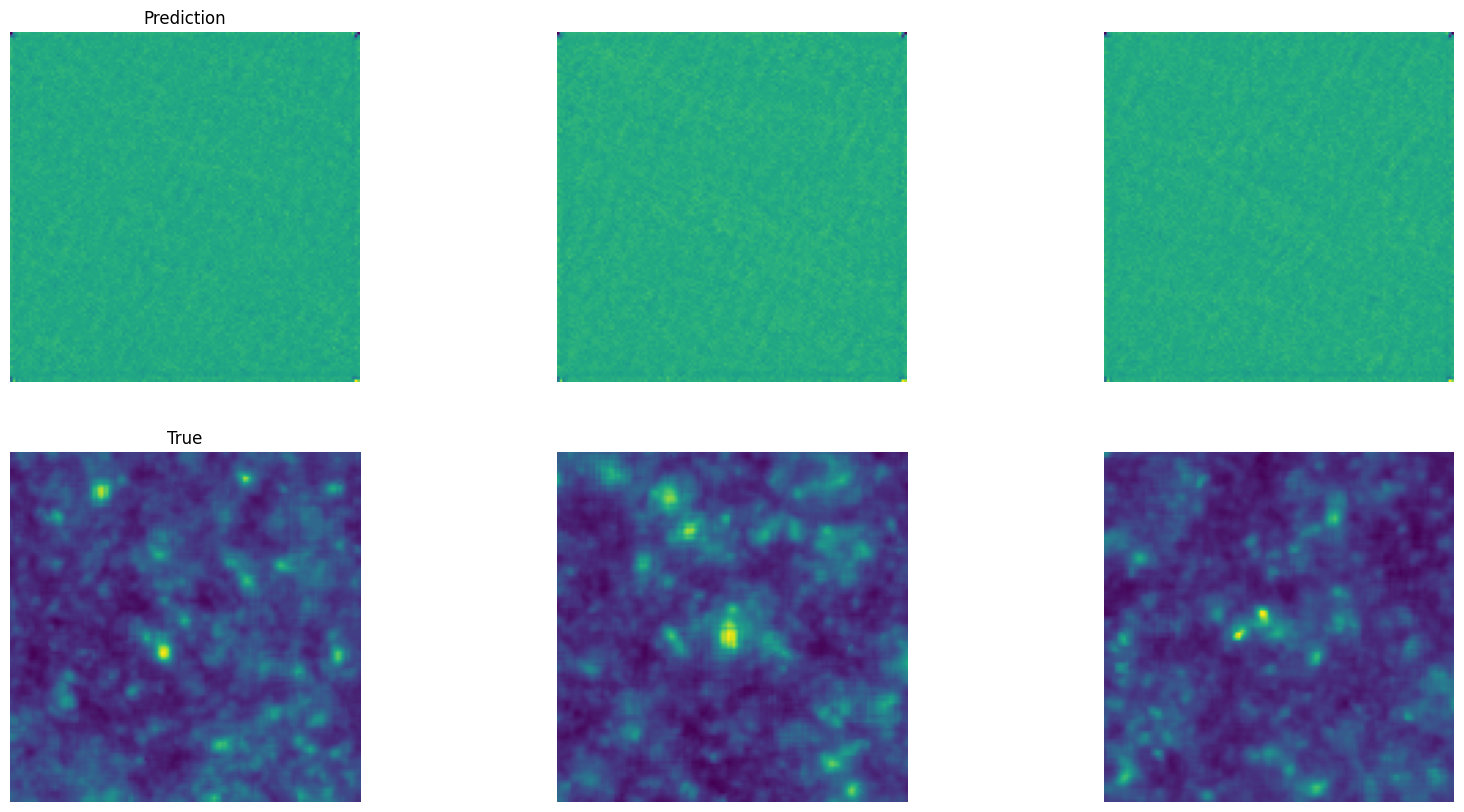

# Training con SSI

In [ ]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


In [ ]:
# TOOD Agregar regularizacion de dropout

def create_SSIM_model(learning_rate=1e-4, 
                 h_kernel_size=3, 
                 hidden_filters=64,
                 out_kernel_size=3,
                 epsilon=1e-7):
    """
    Modelo que agranda las dimensiones espaciales hasta 256x256 y luego las reduce a 128x128.
    """
    initializer = tf.keras.initializers.GlorotNormal()
    input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
    x = tf.keras.layers.BatchNormalization()(input_layer)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation="sigmoid", padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Conv2D(
        hidden_filters, (h_kernel_size, h_kernel_size), kernel_initializer=initializer, 
        activation="softplus", padding='same')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(x)
    output_image = tf.keras.layers.Conv2D(1, (out_kernel_size, out_kernel_size), 
                                          activation="tanh", padding='same', name='output_image', 
                                          kernel_initializer=initializer)(x)


    model = tf.keras.models.Model(inputs=input_layer, 
        outputs=output_image)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                         epsilon=epsilon)

    model.compile(optimizer=optimizer, 
                loss= [ssim_loss],
                metrics={'output_image': ["mse", "mae", metrics.DICEE, metrics.WMAPE]})

    return model


model = create_SSIM_model()
model.summary()



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,101 (238.68 KB)

 Trainable params: 61,095 (238.65 KB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=1000, 
    home=home_data)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=True, callbacks=[time_limit_callback])

Using data folder: ../../data/4
Epoch 1/30
     22/Unknown 14s 586ms/step - dicee: 0.8303 - loss: 0.9919 - mae: 0.7666 - mse: 0.6463 - wmape: 278.5647

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step - dicee: 0.8235 - loss: 0.9916 - mae: 0.7589 - mse: 0.6365 - wmape: 275.1607 - val_dicee: 0.3704 - val_loss: 0.9998 - val_mae: 0.6928 - val_mse: 0.4845 - val_wmape: 208.6543
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 642ms/step - dicee: 0.4352 - loss: 1.0009 - mae: 0.7990 - mse: 0.6474 - wmape: 274.2222 - val_dicee: 0.3718 - val_loss: 0.9999 - val_mae: 0.9143 - val_mse: 0.8390 - val_wmape: 276.0823
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 680ms/step - dicee: 0.4218 - loss: 1.0015 - mae: 0.9207 - mse: 0.8506 - wmape: 307.9073 - val_dicee: 0.3716 - val_loss: 0.9999 - val_mae: 0.9278 - val_mse: 0.8636 - val_wmape: 275.8917
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 690ms/step - dicee: 0.4205 - loss: 1.0020 - mae: 0.9297 - mse: 0.8671 - wmape: 327.1791 - val_dicee: 0.3697 - val_loss: 0.9999 - val_mae: 0.9295 - val_mse: 0.8668 - val_wmape: 281.1526
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 696ms/step - dicee: 0.4203 - loss: 1.0032 - mae: 0.9316 - mse

2024-08-30 12:13:07.893615: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 673ms/step - dicee: 0.4229 - loss: 1.0021 - mae: 0.9340 - mse: 0.8751 - wmape: 327.8048 - val_dicee: 0.3691 - val_loss: 0.9999 - val_mae: 0.9331 - val_mse: 0.8733 - val_wmape: 283.6225
Epoch 13/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 666ms/step - dicee: 0.4203 - loss: 1.0003 - mae: 0.9335 - mse: 0.8742 - wmape: 322.6192 - val_dicee: 0.3695 - val_loss: 0.9999 - val_mae: 0.9335 - val_mse: 0.8742 - val_wmape: 282.9183
Epoch 14/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 679ms/step - dicee: 0.4205 - loss: 1.0026 - mae: 0.9353 - mse: 0.8774 - wmape: 329.2229 - val_dicee: 0.3704 - val_loss: 0.9999 - val_mae: 0.9342 - val_mse: 0.8755 - val_wmape: 275.0834
Epoch 15/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 679ms/step - dicee: 0.4209 - loss: 1.0011 - mae: 0.9351 - mse: 0.8771 - wmape: 331.1646 - val_dicee: 0.3701 - val_loss: 0.9999 - val_mae: 0.9347 - val_mse: 0.8765 - val_wmape: 277.4758
Epoch 16/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 681ms/step - dicee: 0.4195 - loss: 1.0016 - mae: 0.9360 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
(3, 128, 1)


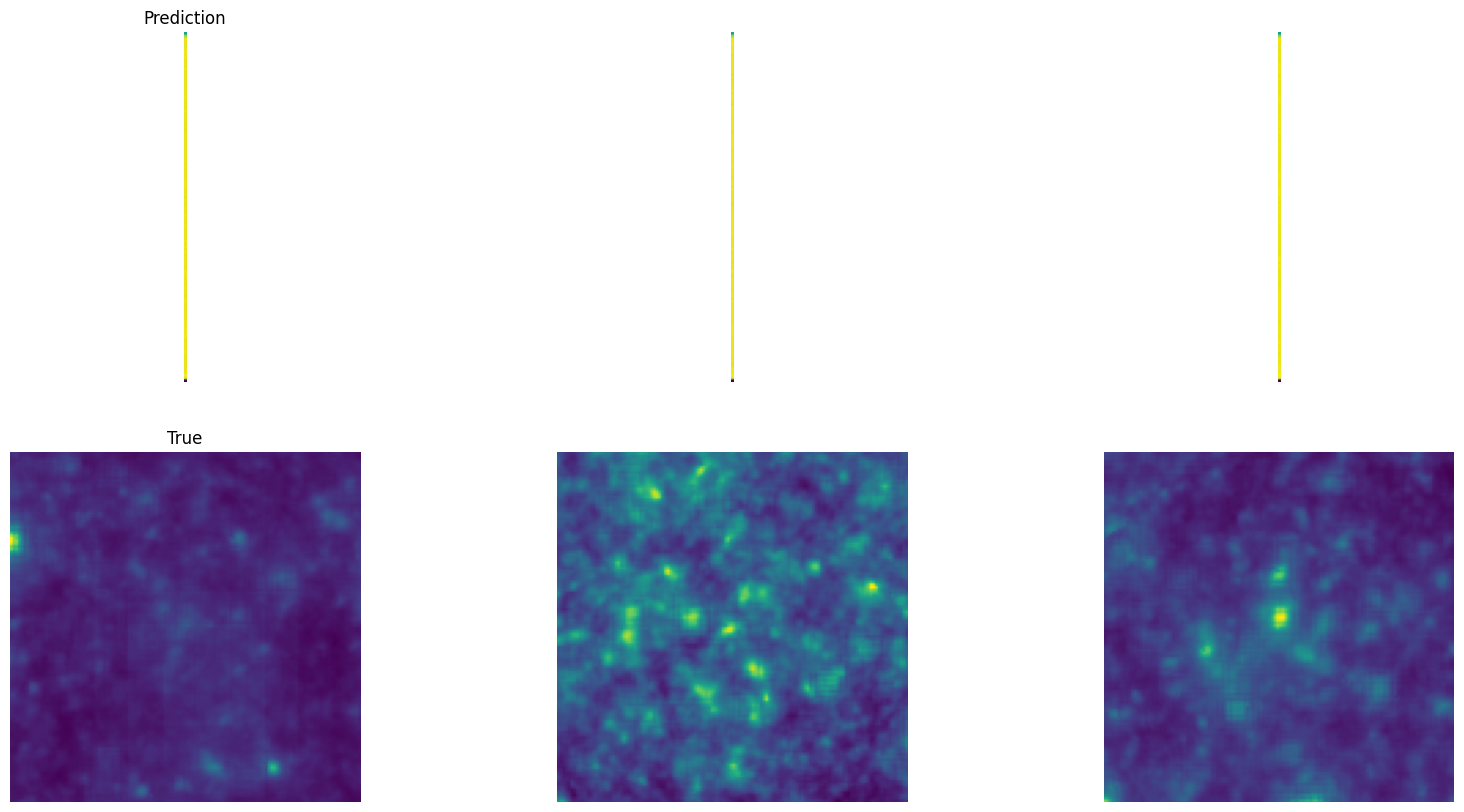

In [ ]:
test_model_image(model, test_dataset)

## Testing Modelo WMAPE

In [ ]:
# TOOD Agregar regularizacion de dropout

def create_WMAPE_model(learning_rate=1e-4, 
                 h_kernel_size=3, 
                 hidden_filters=64,
                 out_kernel_size=3,
                 epsilon=1e-7):
    """
    Modelo que agranda las dimensiones espaciales hasta 256x256 y luego las reduce a 128x128.
    """
    initializer = tf.keras.initializers.GlorotNormal()
    input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
    x = tf.keras.layers.BatchNormalization()(input_layer)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation="sigmoid", padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Conv2D(
        hidden_filters, (h_kernel_size, h_kernel_size), kernel_initializer=initializer, 
        activation="softplus", padding='same')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation="softplus", padding='same', kernel_initializer=initializer)(x)
    output_image = tf.keras.layers.Conv2D(1, (out_kernel_size, out_kernel_size), 
                                          activation="tanh", padding='same', name='output_image', 
                                          kernel_initializer=initializer)(x)


    model = tf.keras.models.Model(inputs=input_layer, 
        outputs=output_image)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                         epsilon=epsilon)

    model.compile(optimizer=optimizer, 
                loss= [metrics.WMAPE],
                metrics={'output_image': ["mse", "mae", metrics.DICEE, metrics.WMAPE]})

    return model


model = create_WMAPE_model()
model.summary()



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,101 (238.68 KB)

 Trainable params: 61,095 (238.65 KB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=1000, 
    home=home_data)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=True, callbacks=[time_limit_callback])

Using data folder: ../../data/4
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 625ms/step - dicee: 0.6220 - loss: 32.2335 - mae: 0.1056 - mse: 0.0234 - wmape: 32.1915 - val_dicee: 0.7493 - val_loss: 5.9555 - val_mae: 0.0341 - val_mse: 0.0046 - val_wmape: 5.1546
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 611ms/step - dicee: 0.6260 - loss: 8.0658 - mae: 0.0387 - mse: 0.0049 - wmape: 8.0489 - val_dicee: 0.7316 - val_loss: 10.4201 - val_mae: 0.0399 - val_mse: 0.0046 - val_wmape: 8.8655
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 618ms/step - dicee: 0.6242 - loss: 9.3722 - mae: 0.0404 - mse: 0.0047 - wmape: 9.3531 - val_dicee: 0.7310 - val_loss: 9.6495 - val_mae: 0.0346 - val_mse: 0.0042 - val_wmape: 8.4422
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 635ms/step - dicee: 0.6278 - loss: 7.4195 - mae: 0.0371 - mse: 0.0043 - wmape: 7.4074 - val_dicee: 0.7207 - val_loss: 4.8571 - val_mae: 0.0326 - val_mse: 0.0037 - val_wmape: 4.1584
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 639ms/step - dicee: 0.6305 - lo

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
(3, 128, 128, 1)


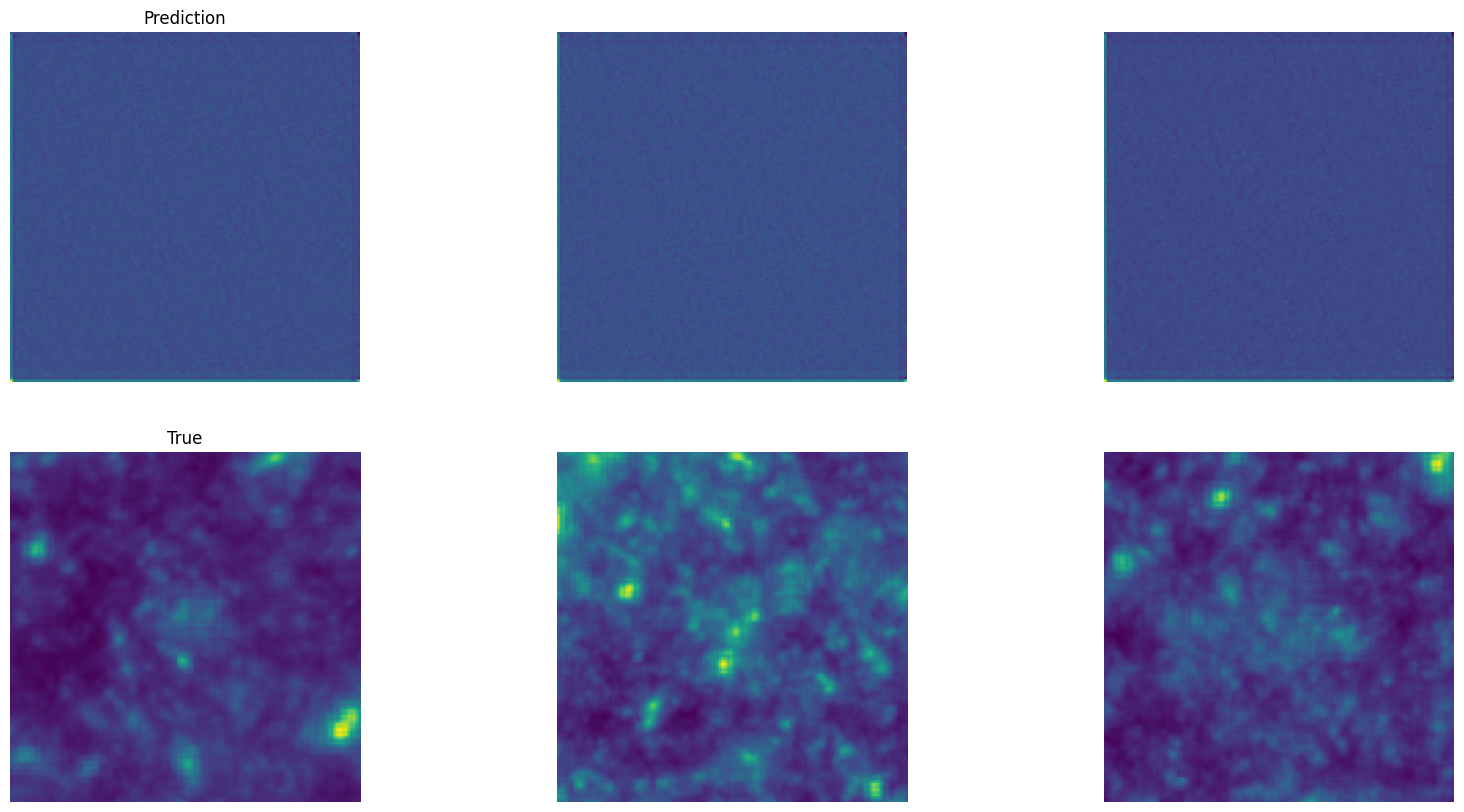

In [ ]:
test_model_image(model, test_dataset, outs=1)